In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats import linregress
from scipy.stats import wilcoxon
from matplotlib.patches import Patch
from collections import defaultdict

---
# - PARAMETER EXTRACTION

---
## 🔍 Función `extract_parameters(path)`

La función `extract_parameters(path)` es el **núcleo del análisis cuantitativo** de cada sesión de DIBH.  
A partir del archivo de datos preprocesados (es decir, aquel que termina en `_processed-data.txt`), la función **extrae todos los parámetros relevantes** para la evaluación de la calidad y estabilidad de la respiración durante el tratamiento.


### 🧩 **Input**

- **`path`**:  
  Ruta (string) de la **carpeta** donde se encuentra el archivo de datos.  
  Dentro de esta carpeta debe existir **exactamente un archivo** cuyo nombre termine en `_processed-data.txt` (por ejemplo: `4989528_4_processed-data.txt`).

> ⚠️ Importante: la función **no recibe directamente el archivo**, sino la **carpeta que lo contiene**.  
> Si hay varios archivos que terminen igual, se toma el primero que se encuentre.


### 📤 **Output**

La función genera **tres tipos de salida**:

1. **Un archivo de texto** `patientID_sesion_results.txt`  
   Contiene una lista de magnitudes con sus valores en el formato: 
   Magnitud = Resultado
   
   Este archivo incluye todos los parámetros calculados (por BH, por grupo y globales).

2. **Un archivo JSON** `patientID_sesion_results.json`  
Contiene la misma información estructurada jerárquicamente (útil para análisis automáticos posteriores).

3. **Un diccionario Python (dict)** que devuelve la función directamente  
Este diccionario contiene las mismas claves y valores que el `.json`.


### ⚙️ **Estructura y lógica general**

La función sigue una lógica estructurada en **siete grandes etapas**:


#### 🧾 1️⃣ Identificación y lectura del archivo

Busca en la carpeta indicada un archivo que termine en `_processed-data.txt`.  
El archivo se carga con `pandas` y puede tener una **fila inicial** (normalmente la segunda línea del fichero) que contenga los **valores de thresholds** (`UpperThreshold` y `LowerThreshold`).  
Si existe esa fila, se detecta automáticamente y se extraen los valores de umbral para toda la sesión.

El DataFrame final contiene las columnas principales:

| Columna | Descripción |
|----------|--------------|
| **Time** | Tiempo (en segundos) |
| **Amplitude** | Desplazamiento de la caja toracica |
| **Beam** | Estado del haz (1 = encendido, 0 = apagado) |
| **Grupo** | Posición o fase del acelerador lineal |
| **UpperThreshold / LowerThreshold** | Límites superior e inferior permitidos para la amplitud |


#### 📈 2️⃣ Identificación de los ciclos de contención (BHs)

Un **BH** (Breath Hold) se define como un intervalo continuo donde `Beam == 1`,  
es decir, el haz está activo.

La función detecta todas las transiciones:
- `Beam` pasa de 0 → 1  → inicio del BH  
- `Beam` pasa de 1 → 0  → fin del BH  

Para cada **BH_i** se almacenan los índices de inicio y final, y se calculan sus características.


#### 📊 3️⃣ Cálculo de parámetros por cada BH

Para cada ciclo de contención (`BH_i`), la función calcula:

| Parámetro | Símbolo | Definición |
|------------|----------|------------|
| **Duración** | Δt<sub>BH_i</sub> | Tiempo entre el inicio y fin del BH. |
| **Amplitud media** | RE<sub>BH_i</sub> | Media aritmética de la amplitud durante el BH. |
| **Desviación estándar (STD)** | S<sub>BH_i</sub>(STD) | Dispersión de la señal dentro del BH. |
| **Drift o pendiente de deriva** | Drift<sub>BH_i</sub> | Pendiente de la regresión lineal de Amplitude vs Time (mide la tendencia durante el BH). |
| **Variación de amplitud** | Amplitude_Variation<sub>i</sub> | |Drift<sub>BH_i</sub>| × Δt<sub>BH_i</sub>, mide cuánto cambia la amplitud total durante el BH. |

Además, cada BH queda asociado al valor del **grupo** (`Grupo`) en el instante de inicio.


#### 🧮 4️⃣ Cálculo de parámetros por Grupo

Los **grupos** (`Grupo == i`) representan diferentes posiciones del acelerador.  
Dentro de cada grupo, la función evalúa:

| Parámetro | Símbolo | Descripción |
|------------|----------|-------------|
| **Duración del grupo** | Δt<sub>g_i</sub> | Tiempo total del intervalo donde `Grupo == i`. |
| **Número de BH** | num_BH | Cantidad de BHs ocurridos dentro del grupo. |
| **BH fallidos** | Failed_BH | Número de BHs con duración < 15 s (exceptuando el último si el grupo termina simultáneamente con el fin del BH). |
| **Paradas largas** | LongStops | Veces que `Beam == 0` durante más de 10 s dentro del grupo. |


#### 🧭 5️⃣ Cálculo de parámetros globales de la sesión

Estos parámetros resumen el rendimiento global del tratamiento:

| Parámetro | Símbolo | Definición |
|------------|----------|------------|
| **Tiempo total de tratamiento** | TTT | Último valor de `Time` − primero. |
| **Tiempo total de haz activo** | TBT | Suma de las duraciones de todos los BHs. |
| **Eficiencia del tratamiento** | Time_effectiveness | TBT / TTT. |
| **Amplitud media global** | mean_Amp | Media aritmética de todos los RE<sub>BH_i</sub>. |
| **Dispersión global de la amplitud** | std_Amp | Desviación de los valores RE<sub>BH_i</sub> respecto a mean_Amp. |
| **Coeficientes de variación de amplitud** | CV_amp | std_Amp/mean_Amp. |
| **Error medio absoluto** | MAE | Media de |Amplitude − RE<sub>f</sub>| cuando `Beam == 1`. |
| **Pequeñas excursiones** | NLE | Número de veces que la amplitud sobrepasa los thresholds y vuelve dentro en menos de 1 s. |
| **Duración media de los BH** | mean(Δt<sub>BH</sub>) | Promedio de las duraciones de todos los BHs. |
| **Desviación estandar del BH** | std(Δt<sub>BH</sub>) | Desviación estandar de la duración de todos los BHs. |
| **Coeficiente de variación de BH** | CV_BH | std(Δt<sub>BH</sub>) / mean(Δt<sub>BH</sub>) |
| **Número total de BH** | Total_BH | Número de BH total en la sesión. |
| **Número de BH fallidos** | Failed_BH_total | Número de BH con una duración inferior a 15s. |
| **Effectividad del BH** | BH_Effectiveness | (1 - Failed_BH_total/Total_BH) |
| **Paradas largas globales** | LongStops_global | Número de intervalos con `Beam==0` mayores a 10 s en toda la sesión. |


#### 📁 6️⃣ Estructura de la salida

El diccionario (y el JSON) devuelto por la función tiene esta jerarquía:

```python
{
    
"sourcefile": "4989528_4_processed-data.txt",
    
"UpperThreshold": ...,
    
"LowerThreshold": ...,
    
"HoldAmplitudeRange": ...,
    
"BHs": [
    
   { "BH_index": 1, "duration": ..., "RE": ..., "RMSE": ..., ... },
    
   { "BH_index": 2, "duration": ..., ... },
    
   ...
    
],
    
"Groups": {
    
   1: {"Delta_t_g": ..., "num_BH": ..., "Failed_BH": ..., "LongStops": ...},
    
   2: {...},
    
   ...
    
},
    
"Session": {
    
   "TTT": ...,
    
   "TBT": ...,
    
   "Effectiveness": ...,
    
   "RE_f": ...,
    
   "CV_RMSE": ...,
    
   ...
    
}
    
} ```


### 💾 7️⃣ Escritura de resultados

Finalmente, la función guarda:

patientID_sesion_results.txt

→ Legible y orientado a lectura humana.

Cada línea contiene una magnitud y su valor, por ejemplo:

Upper threshold = 0.85

Lower threshold = 0.65

HoldAmplitudeRange = 0.20

Delta t_BH_1 = 18.24

RE_BH_1 = 0.73

...

patientID_sesion_results.json

→ Mismo contenido estructurado, ideal para carga automática en análisis o visualizaciones. 

In [17]:
def extract_parameters(path: str) -> dict:

    # --- 1️⃣ Buscar archivo *_processed-data.txt ---
    files = [f for f in os.listdir(path) if f.endswith('_processed-data.txt')]
    if len(files) == 0:
        raise FileNotFoundError(f"No se encontró ningún archivo '*_processed-data.txt' en {path}")
    infile = os.path.join(path, files[0])
    basename = os.path.splitext(files[0])[0].replace('_processed-data', '')
    out_txt = os.path.join(path, f"{basename}_results.txt")
    out_json = os.path.join(path, f"{basename}_results.json")

    # --- 2️⃣ Cargar datos y detectar thresholds ---
    df_raw = pd.read_csv(infile, sep="\t", header=0, dtype=str)

    for col in ["Time", "Amplitude", "Beam", "Grupo", "UpperThreshold", "LowerThreshold"]:
        if col in df_raw.columns:
            df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

    thr_row = df_raw.loc[df_raw["UpperThreshold"].notna() & df_raw["LowerThreshold"].notna()]
    if thr_row.shape[0] == 0:
        raise ValueError("No se encontraron los valores de Upper/Lower Threshold en el archivo.")
    thr_idx = thr_row.index[0]
    upper_th = float(df_raw.at[thr_idx, "UpperThreshold"])
    lower_th = float(df_raw.at[thr_idx, "LowerThreshold"])
    hold_range = upper_th - lower_th

    df = df_raw.loc[df_raw["Time"].notna()].copy()
    df = df.sort_values("Time").reset_index(drop=True)
    df["Time"] = df["Time"].astype(float)
    df["Amplitude"] = df["Amplitude"].astype(float)
    df["Beam"] = df["Beam"].fillna(0).astype(int)
    df["Grupo"] = df["Grupo"].fillna(0).astype(int)

    # --- 3️⃣ Detectar BHs (intervalos con Beam == 1) ---
    beam = df["Beam"].values
    times = df["Time"].values
    amps = df["Amplitude"].values
    grupos = df["Grupo"].values

    starts, ends = [], []
    in_bh = False
    start_idx = None
    for i, b in enumerate(beam):
        if not in_bh and b == 1:
            in_bh = True
            start_idx = i
        elif in_bh and b == 0:
            in_bh = False
            ends.append(i - 1)
            starts.append(start_idx)
    if in_bh and start_idx is not None:
        ends.append(len(beam) - 1)
        starts.append(start_idx)

    # --- 4️⃣ Calcular parámetros por BH ---
    BH_list = []
    for k, (s, e) in enumerate(zip(starts, ends), start=1):
        t_start, t_end = times[s], times[e]
        duration = t_end - t_start
        seg_amp = amps[s:e + 1]
        seg_time = times[s:e + 1]

        RE = np.mean(seg_amp)
        STD = np.std(seg_amp)
        try:
            p = np.polyfit(seg_time, seg_amp, 1)
            Drift = p[0]
        except Exception:
            Drift = np.nan

        AmpVar = abs(Drift * duration) if np.isfinite(Drift) else np.nan
        BH_list.append({
            "BH_index": k,
            "t_start": t_start,
            "t_end": t_end,
            "duration": duration,
            "RE": RE,
            "STD": STD,
            "Drift": Drift,
            "Amplitude_Variation": AmpVar,
            "group_at_start": int(grupos[s]) if not np.isnan(grupos[s]) else np.nan
        })

    # --- 5️⃣ Calcular parámetros por grupo ---
    groups = {}
    unique_groups = sorted([g for g in df["Grupo"].unique() if g != 0])
    for g in unique_groups:
        idx = df.index[df["Grupo"] == g]
        if len(idx) == 0:
            continue
        t0, t1 = df.loc[idx[0], "Time"], df.loc[idx[-1], "Time"]
        delta_t_g = t1 - t0
        bh_in_g = [bh for bh in BH_list if bh["group_at_start"] == g]
        num_BH = len(bh_in_g)

        failed = 0
        for bh in bh_in_g:
            if bh["duration"] < 15:
                end_idx = bh["t_end"]
                is_last = bh == bh_in_g[-1]
                exclude = False
                if is_last:
                    idx_after = np.searchsorted(times, end_idx) + 1
                    if idx_after < len(df) and df.loc[idx_after, "Grupo"] == 0:
                        exclude = True
                if not exclude:
                    failed += 1

        sub = df.loc[idx].reset_index(drop=True)
        bs = sub["Beam"].values
        ts = sub["Time"].values
        long_stops = 0
        in_zero, zero_start = False, None
        for i, b in enumerate(bs):
            if not in_zero and b == 0:
                in_zero, zero_start = True, ts[i]
            elif in_zero and b == 1:
                dur = ts[i - 1] - zero_start
                if dur > 10:
                    long_stops += 1
                in_zero = False
        if in_zero:
            dur = ts[-1] - zero_start
            if dur > 10:
                long_stops += 1

        groups[int(g)] = {
            "Delta_t_g": delta_t_g,
            "num_BH": num_BH,
            "Failed_BH": failed,
            "LongStops": long_stops
        }

    # --- 6️⃣ Parámetros globales ---
    TTT = df["Time"].iloc[-1] - df["Time"].iloc[0]
    TBT = sum([bh["duration"] for bh in BH_list])
    Time_effectiveness = TBT / TTT if TTT else np.nan

    RE_vals = np.array([bh["RE"] for bh in BH_list])
    dur_vals = np.array([bh["duration"] for bh in BH_list])

    mean_Amp = np.mean(RE_vals)
    std_Amp = np.std(RE_vals)
    CV_Amp = std_Amp / mean_Amp if mean_Amp else np.nan

    mask_beam1 = df["Beam"] == 1
    amps_beam1 = df.loc[mask_beam1, "Amplitude"].dropna().values
    MAE = np.mean(np.abs(amps_beam1 - mean_Amp)) if len(amps_beam1) > 0 else np.nan

    # --- NLE: pequeñas excursiones ---
    NLE_times = []
    if (upper_th is not None) and (lower_th is not None):
        amp = df['Amplitude'].values
        t = df['Time'].values
        i, N = 0, len(amp)
        while i < N:
            if np.isnan(amp[i]):
                i += 1
                continue
            out_high = amp[i] > upper_th
            out_low = amp[i] < lower_th
            if out_high or out_low:
                start_t = t[i]
                j = i + 1
                while j < N and (amp[j] > upper_th or amp[j] < lower_th):
                    j += 1
                if j < N:
                    dur = t[j] - start_t
                    if dur < 1.0:
                        NLE_times.append(start_t)
                    i = j + 1
                else:
                    break
            else:
                i += 1

        # Filtrar NLE consecutivas (<1 s entre sí)
        NLE_times.sort()
        filtered_NLE = []
        for nt in NLE_times:
            if not filtered_NLE or (nt - filtered_NLE[-1]) >= 1.0:
                filtered_NLE.append(nt)
        NLE = len(filtered_NLE)
    else:
        NLE = np.nan

    # --- Estadísticos BH ---
    mean_BH = np.mean(dur_vals) if len(dur_vals) > 0 else np.nan
    std_BH = np.std(dur_vals) if len(dur_vals) > 0 else np.nan
    CV_BH = std_BH / mean_BH if mean_BH else np.nan

    total_BH = len(BH_list)
    failed_total = sum([g["Failed_BH"] for g in groups.values()])
    BH_effectiveness = (1- failed_total/total_BH) if total_BH > 0 else np.nan
    total_LongStops = sum([g["LongStops"] for g in groups.values()])

    # --- 7️⃣ Guardar resultados ---
    results = {
        "sourcefile": files[0],
        "UpperThreshold": upper_th,
        "LowerThreshold": lower_th,
        "HoldAmplitudeRange": hold_range,
        "BHs": BH_list,
        "Groups": groups,
        "Session": {
            "TTT": TTT,
            "TBT": TBT,
            "Time_effectiveness": Time_effectiveness,
            "mean_Amp": mean_Amp,
            "std_Amp": std_Amp,
            "CV_Amp": CV_Amp,
            "MAE": MAE,
            "NLE": NLE,
            "mean_BH": mean_BH,
            "std_BH": std_BH,
            "CV_BH": CV_BH,
            "Total_BH": total_BH,
            "Failed_BH_total": failed_total,
            "BH_effectiveness": BH_effectiveness,
            "Long_stops": total_LongStops
        }
    }

    # --- 8️⃣ Crear TXT con formato ---
    lines = []
    lines.append("=====================================")
    lines.append("📄 INFORMACIÓN GENERAL DEL ARCHIVO")
    lines.append("=====================================")
    lines.append(f"Source file = {results['sourcefile']}")
    lines.append(f"Upper threshold = {upper_th}")
    lines.append(f"Lower threshold = {lower_th}")
    lines.append(f"HoldAmplitudeRange = {hold_range}\n")

    lines.append("=====================================")
    lines.append("💨 PARÁMETROS POR BH")
    lines.append("=====================================")
    for bh in BH_list:
        i = bh["BH_index"]
        lines.append(f"\n--- BH_{i} ---")
        lines.append(f"Delta t_BH_{i} = {bh['duration']:.3f}")
        lines.append(f"RE_BH_{i} = {bh['RE']:.3f}")
        lines.append(f"S_BH_{i}(STD) = {bh['STD']:.5f}")
        lines.append(f"Drift_BH_{i} = {bh['Drift']:.5f}")
        lines.append(f"Amplitude_Variation_{i} = {bh['Amplitude_Variation']:.5f}")

    lines.append("\n=====================================")
    lines.append("⚙️ PARÁMETROS POR GRUPO")
    lines.append("=====================================")
    for g, gd in groups.items():
        lines.append(f"\n--- Grupo {g} ---")
        lines.append(f"Delta t_g_{g} = {gd['Delta_t_g']:.3f}")
        lines.append(f"num_BH_g_{g} = {gd['num_BH']}")
        lines.append(f"Failed_BH_g_{g} = {gd['Failed_BH']}")
        lines.append(f"LongStops_g_{g} = {gd['LongStops']}")

    lines.append("\n=====================================")
    lines.append("⏱️ PARÁMETROS GLOBALES DE SESIÓN")
    lines.append("=====================================")
    for k, v in results["Session"].items():
        if isinstance(v, float):
            lines.append(f"{k} = {v:.5f}")
        else:
            lines.append(f"{k} = {v}")

    with open(out_txt, "w", encoding="utf-8") as f:
        for line in lines:
            f.write(line + "\n")

    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    return results


---------------  
## Función `extract_all_parameters(base_path)`

**Finalidad:**  
Ejecuta automáticamente la función `extract_parameters()` para **todos los pacientes y sesiones** dentro de una carpeta raíz (`base_path`).  
Busca los archivos con formato `*_processed-data.txt`, los analiza, y genera los resultados correspondientes (`*_results.txt` y `*_results.json`) en las mismas carpetas. Devuelve un `DataFrame` resumen con el estado del procesamiento.


### 🧭 Flujo de trabajo
1. **Entrada:** recibe la ruta base (`base_path`) con las carpetas de pacientes.  
2. **Exploración:** recorre recursivamente las subcarpetas con `os.walk()`.  
3. **Detección:** identifica los archivos que terminan en `_processed-data.txt` (ignora los demás).  
4. **Procesamiento:** para cada archivo válido:
   - Obtiene `patientID` y `sesión` del nombre del archivo.  
   - Llama a `extract_parameters(path)` → calcula métricas DIBH, genera:
     - `patientID_session_results.txt`  
     - `patientID_session_results.json`  
   - Ambos se guardan en la misma carpeta del archivo original.  
   - Si ocurre un error, se registra el mensaje en el resumen.
5. **Salida:** genera un `DataFrame` con columnas:
   - `Paciente` — ID del paciente  
   - `Sesion` — número de sesión  
   - `RutaArchivo` — ruta completa  
   - `Resultado` — “OK” o descripción del error  
   e imprime un resumen general de todos los casos.


### 📁 Estructura esperada de carpetas
Pacientes/

├── 5816752/

│ ├── 5816752_1_processed-data.txt

│ ├── 5816752_2_processed-data.txt

│ └── ...

├── 5839011/

│ ├── 5839011_1_processed-data.txt

│ ├── 5839011_2_processed-data.txt

│ └── ...

### 📤 Outputs
- **Archivos generados (por sesión):**
  - `patientID_session_results.txt` → informe legible con métricas DIBH (UTF-8).  
  - `patientID_session_results.json` → estructura jerárquica (meta, grupos, resumen).  
- **Valor retornado:**  
  `df_resultados` *(pandas.DataFrame)* con columnas:
  | Paciente | Sesion | RutaArchivo | Resultado |
  |-----------|---------|-------------|------------|
  | 5816752 | 1 | C:\...\5816752_1_processed-data.txt | OK |
  | 5839011 | 1 | C:\...\5839011_1_processed-data.txt | Error: archivo vacío |


In [19]:
def extract_all_parameters(base_path, pattern_suffix="_processed-data.txt", verbose=True):
    """
    Aplica extract_parameters y build_plot a todos los archivos *_processed-data.txt
    dentro de una carpeta (y sus subcarpetas).

    ✅ Modificación:
    - extract_parameters ahora recibe la carpeta (root) en lugar del archivo completo.
    """

    resultados_globales = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if not file.endswith(pattern_suffix):
                continue

            path = os.path.join(root, file)
            name = file.replace(pattern_suffix, "")
            patient_id = name.split("_")[0] if "_" in name else name
            session_id = name.split("_")[1] if "_" in name else ""

            txt_path = os.path.join(root, f"{name}_results.txt")
            json_path = os.path.join(root, f"{name}_results.json")
            plot_path = path.replace("_processed-data.txt", "_plot.png")

            try:
                # 1️⃣ Calcular parámetros → ahora recibe la CARPETA (root)
                extract_parameters(root)

                if verbose:
                    print(f"\n✅ Procesado: {file}")
                    print(f"  ├─ Results TXT:  {txt_path}")
                    print(f"  ├─ Results JSON: {json_path}")

            except Exception as e:
                print(f"\n❌ Error procesando {file}: {e}")

    print("\n🎯 Procesamiento completado para todos los archivos.")


In [30]:
base_path = r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes"
df_summary = extract_all_parameters(base_path)


✅ Procesado: 238407_1_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\238407\238407_1\238407_1_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\238407\238407_1\238407_1_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\238407\238407_1\238407_1_plot.png

✅ Procesado: 238407_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\238407\238407_10\238407_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\238407\238407_10\238407_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\238407\238407_10\238407_10_plot.png

✅ Procesado: 238407_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\238407\2384


✅ Procesado: 351756_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\351756\351756_14\351756_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\351756\351756_14\351756_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\351756\351756_14\351756_14_plot.png

✅ Procesado: 351756_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\351756\351756_15\351756_15_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\351756\351756_15\351756_15_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\351756\351756_15\351756_15_plot.png

✅ Procesado: 351756_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\35175


✅ Procesado: 409789_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\409789\409789_5\409789_5_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\409789\409789_5\409789_5_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\409789\409789_5\409789_5_plot.png

✅ Procesado: 409789_6_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\409789\409789_6\409789_6_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\409789\409789_6\409789_6_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\409789\409789_6\409789_6_plot.png

✅ Procesado: 409789_7_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\409789\409789_7\409


✅ Procesado: 4249914_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4249914\4249914_10\4249914_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4249914\4249914_10\4249914_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4249914\4249914_10\4249914_10_plot.png

✅ Procesado: 4249914_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4249914\4249914_11\4249914_11_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4249914\4249914_11\4249914_11_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4249914\4249914_11\4249914_11_plot.png

✅ Procesado: 4249914_12_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 4666492_1_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4666492\4666492_1\4666492_1_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4666492\4666492_1\4666492_1_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4666492\4666492_1\4666492_1_plot.png

✅ Procesado: 4666492_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4666492\4666492_10\4666492_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4666492\4666492_10\4666492_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4666492\4666492_10\4666492_10_plot.png

✅ Procesado: 4666492_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\


✅ Procesado: 4820302_13_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4820302\4820302_13\4820302_13_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4820302\4820302_13\4820302_13_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4820302\4820302_13\4820302_13_plot.png

✅ Procesado: 4820302_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4820302\4820302_14\4820302_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4820302\4820302_14\4820302_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4820302\4820302_14\4820302_14_plot.png

✅ Procesado: 4820302_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 4922594_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4922594\4922594_3\4922594_3_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4922594\4922594_3\4922594_3_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4922594\4922594_3\4922594_3_plot.png

✅ Procesado: 4922594_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4922594\4922594_4\4922594_4_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4922594\4922594_4\4922594_4_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4922594\4922594_4\4922594_4_plot.png

✅ Procesado: 4922594_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 4927957_7_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4927957\4927957_7\4927957_7_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4927957\4927957_7\4927957_7_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4927957\4927957_7\4927957_7_plot.png

✅ Procesado: 4927957_8_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4927957\4927957_8\4927957_8_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4927957\4927957_8\4927957_8_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\4927957\4927957_8\4927957_8_plot.png

✅ Procesado: 4927957_9_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5191204_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5191204\5191204_10\5191204_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5191204\5191204_10\5191204_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5191204\5191204_10\5191204_10_plot.png

✅ Procesado: 5191204_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5191204\5191204_11\5191204_11_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5191204\5191204_11\5191204_11_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5191204\5191204_11\5191204_11_plot.png

✅ Procesado: 5191204_12_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 5308157_1_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5308157\5308157_1\5308157_1_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5308157\5308157_1\5308157_1_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5308157\5308157_1\5308157_1_plot.png

✅ Procesado: 5308157_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5308157\5308157_10\5308157_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5308157\5308157_10\5308157_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5308157\5308157_10\5308157_10_plot.png

✅ Procesado: 5308157_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\


✅ Procesado: 5401072_13_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5401072\5401072_13\5401072_13_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5401072\5401072_13\5401072_13_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5401072\5401072_13\5401072_13_plot.png

✅ Procesado: 5401072_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5401072\5401072_14\5401072_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5401072\5401072_14\5401072_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5401072\5401072_14\5401072_14_plot.png

✅ Procesado: 5401072_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 5632755_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5632755\5632755_3\5632755_3_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5632755\5632755_3\5632755_3_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5632755\5632755_3\5632755_3_plot.png

✅ Procesado: 5632755_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5632755\5632755_4\5632755_4_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5632755\5632755_4\5632755_4_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5632755\5632755_4\5632755_4_plot.png

✅ Procesado: 5632755_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5645443_7_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5645443\5645443_7\5645443_7_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5645443\5645443_7\5645443_7_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5645443\5645443_7\5645443_7_plot.png

✅ Procesado: 5645443_8_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5645443\5645443_8\5645443_8_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5645443\5645443_8\5645443_8_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5645443\5645443_8\5645443_8_plot.png

✅ Procesado: 5645443_9_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5679043_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5679043\5679043_10\5679043_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5679043\5679043_10\5679043_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5679043\5679043_10\5679043_10_plot.png

✅ Procesado: 5679043_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5679043\5679043_11\5679043_11_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5679043\5679043_11\5679043_11_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5679043\5679043_11\5679043_11_plot.png

✅ Procesado: 5679043_12_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 5685135_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5685135\5685135_14\5685135_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5685135\5685135_14\5685135_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5685135\5685135_14\5685135_14_plot.png

✅ Procesado: 5685135_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5685135\5685135_15\5685135_15_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5685135\5685135_15\5685135_15_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5685135\5685135_15\5685135_15_plot.png

✅ Procesado: 5685135_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA E


✅ Procesado: 5691706_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5691706\5691706_4\5691706_4_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5691706\5691706_4\5691706_4_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5691706\5691706_4\5691706_4_plot.png

✅ Procesado: 5691706_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5691706\5691706_5\5691706_5_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5691706\5691706_5\5691706_5_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5691706\5691706_5\5691706_5_plot.png

✅ Procesado: 5691706_6_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5694393_8_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694393\5694393_8\5694393_8_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694393\5694393_8\5694393_8_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694393\5694393_8\5694393_8_plot.png

✅ Procesado: 5694393_9_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694393\5694393_9\5694393_9_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694393\5694393_9\5694393_9_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694393\5694393_9\5694393_9_plot.png

✅ Procesado: 5694660_1_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5694921_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694921\5694921_11\5694921_11_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694921\5694921_11\5694921_11_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694921\5694921_11\5694921_11_plot.png

✅ Procesado: 5694921_12_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694921\5694921_12\5694921_12_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694921\5694921_12\5694921_12_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5694921\5694921_12\5694921_12_plot.png

✅ Procesado: 5694921_13_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 5696623_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5696623\5696623_15\5696623_15_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5696623\5696623_15\5696623_15_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5696623\5696623_15\5696623_15_plot.png

✅ Procesado: 5696623_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5696623\5696623_2\5696623_2_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5696623\5696623_2\5696623_2_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5696623\5696623_2\5696623_2_plot.png

✅ Procesado: 5696623_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\P


✅ Procesado: 5697381_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5697381\5697381_5\5697381_5_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5697381\5697381_5\5697381_5_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5697381\5697381_5\5697381_5_plot.png

✅ Procesado: 5697381_6_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5697381\5697381_6\5697381_6_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5697381\5697381_6\5697381_6_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5697381\5697381_6\5697381_6_plot.png

✅ Procesado: 5697381_7_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5703083_9_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5703083\5703083_9\5703083_9_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5703083\5703083_9\5703083_9_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5703083\5703083_9\5703083_9_plot.png

✅ Procesado: 5704780_1_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5704780\5704780_1\5704780_1_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5704780\5704780_1\5704780_1_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5704780\5704780_1\5704780_1_plot.png

✅ Procesado: 5704780_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacient


✅ Procesado: 5706305_12_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5706305\5706305_12\5706305_12_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5706305\5706305_12\5706305_12_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5706305\5706305_12\5706305_12_plot.png

✅ Procesado: 5706305_13_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5706305\5706305_13\5706305_13_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5706305\5706305_13\5706305_13_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5706305\5706305_13\5706305_13_plot.png

✅ Procesado: 5706305_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 5722252_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5722252\5722252_2\5722252_2_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5722252\5722252_2\5722252_2_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5722252\5722252_2\5722252_2_plot.png

✅ Procesado: 5722252_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5722252\5722252_3\5722252_3_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5722252\5722252_3\5722252_3_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5722252\5722252_3\5722252_3_plot.png

✅ Procesado: 5722252_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5746911_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5746911\5746911_2\5746911_2_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5746911\5746911_2\5746911_2_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5746911\5746911_2\5746911_2_plot.png

✅ Procesado: 5746911_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5746911\5746911_3\5746911_3_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5746911\5746911_3\5746911_3_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5746911\5746911_3\5746911_3_plot.png

✅ Procesado: 5746911_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5752601_1_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5752601\5752601_1\5752601_1_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5752601\5752601_1\5752601_1_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5752601\5752601_1\5752601_1_plot.png

✅ Procesado: 5752601_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5752601\5752601_10\5752601_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5752601\5752601_10\5752601_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5752601\5752601_10\5752601_10_plot.png

✅ Procesado: 5752601_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\


✅ Procesado: 5755047_13_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5755047\5755047_13\5755047_13_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5755047\5755047_13\5755047_13_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5755047\5755047_13\5755047_13_plot.png

✅ Procesado: 5755047_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5755047\5755047_14\5755047_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5755047\5755047_14\5755047_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5755047\5755047_14\5755047_14_plot.png

✅ Procesado: 5755047_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 5758387_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5758387\5758387_3\5758387_3_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5758387\5758387_3\5758387_3_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5758387\5758387_3\5758387_3_plot.png

✅ Procesado: 5758387_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5758387\5758387_4\5758387_4_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5758387\5758387_4\5758387_4_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5758387\5758387_4\5758387_4_plot.png

✅ Procesado: 5758387_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5759078_7_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5759078\5759078_7\5759078_7_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5759078\5759078_7\5759078_7_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5759078\5759078_7\5759078_7_plot.png

✅ Procesado: 5759078_8_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5759078\5759078_8\5759078_8_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5759078\5759078_8\5759078_8_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5759078\5759078_8\5759078_8_plot.png

✅ Procesado: 5759078_9_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5764179_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5764179\5764179_14\5764179_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5764179\5764179_14\5764179_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5764179\5764179_14\5764179_14_plot.png

✅ Procesado: 5764179_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5764179\5764179_15\5764179_15_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5764179\5764179_15\5764179_15_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5764179\5764179_15\5764179_15_plot.png

✅ Procesado: 5764179_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA E


✅ Procesado: 5804689_13_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5804689\5804689_13\5804689_13_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5804689\5804689_13\5804689_13_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5804689\5804689_13\5804689_13_plot.png

✅ Procesado: 5804689_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5804689\5804689_14\5804689_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5804689\5804689_14\5804689_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5804689\5804689_14\5804689_14_plot.png

✅ Procesado: 5804689_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA 


✅ Procesado: 5810779_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5810779\5810779_3\5810779_3_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5810779\5810779_3\5810779_3_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5810779\5810779_3\5810779_3_plot.png

✅ Procesado: 5810779_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5810779\5810779_4\5810779_4_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5810779\5810779_4\5810779_4_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5810779\5810779_4\5810779_4_plot.png

✅ Procesado: 5810779_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 5827916_7_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5827916\5827916_7\5827916_7_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5827916\5827916_7\5827916_7_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5827916\5827916_7\5827916_7_plot.png

✅ Procesado: 5827916_8_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5827916\5827916_8\5827916_8_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5827916\5827916_8\5827916_8_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\5827916\5827916_8\5827916_8_plot.png

✅ Procesado: 5827916_9_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Paciente


✅ Procesado: 70212074_10_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70212074\70212074_10\70212074_10_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70212074\70212074_10\70212074_10_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70212074\70212074_10\70212074_10_plot.png

✅ Procesado: 70212074_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70212074\70212074_11\70212074_11_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70212074\70212074_11\70212074_11_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70212074\70212074_11\70212074_11_plot.png

✅ Procesado: 70212074_12_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG 


✅ Procesado: 70232612_14_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70232612\70232612_14\70232612_14_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70232612\70232612_14\70232612_14_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70232612\70232612_14\70232612_14_plot.png

✅ Procesado: 70232612_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70232612\70232612_15\70232612_15_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70232612\70232612_15\70232612_15_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70232612\70232612_15\70232612_15_plot.png

✅ Procesado: 70232612_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG C


✅ Procesado: 70360545_4_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70360545\70360545_4\70360545_4_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70360545\70360545_4\70360545_4_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70360545\70360545_4\70360545_4_plot.png

✅ Procesado: 70360545_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70360545\70360545_5\70360545_5_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70360545\70360545_5\70360545_5_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70360545\70360545_5\70360545_5_plot.png

✅ Procesado: 70360545_6_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH


✅ Procesado: 70499039_8_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70499039\70499039_8\70499039_8_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70499039\70499039_8\70499039_8_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70499039\70499039_8\70499039_8_plot.png

✅ Procesado: 70499039_9_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70499039\70499039_9\70499039_9_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70499039\70499039_9\70499039_9_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70499039\70499039_9\70499039_9_plot.png

✅ Procesado: 70503728_1_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH


✅ Procesado: 70666062_11_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70666062\70666062_11\70666062_11_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70666062\70666062_11\70666062_11_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70666062\70666062_11\70666062_11_plot.png

✅ Procesado: 70666062_12_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70666062\70666062_12\70666062_12_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70666062\70666062_12\70666062_12_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\70666062\70666062_12\70666062_12_plot.png

✅ Procesado: 70666062_13_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG 


✅ Procesado: 762722_15_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\762722\762722_15\762722_15_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\762722\762722_15\762722_15_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\762722\762722_15\762722_15_plot.png

✅ Procesado: 762722_2_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\762722\762722_2\762722_2_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\762722\762722_2\762722_2_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\762722\762722_2\762722_2_plot.png

✅ Procesado: 762722_3_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\762722\76272


✅ Procesado: 80007806_5_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\80007806\80007806_5\80007806_5_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\80007806\80007806_5\80007806_5_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\80007806\80007806_5\80007806_5_plot.png

✅ Procesado: 80007806_6_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\80007806\80007806_6\80007806_6_results.txt
  ├─ Results JSON: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\80007806\80007806_6\80007806_6_results.json
  └─ Plot PNG:     C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes\80007806\80007806_6\80007806_6_plot.png

✅ Procesado: 80007806_7_processed-data.txt
  ├─ Results TXT:  C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH

---
# - Parameter Assessment

---
### Función `enumerate_things`

La función `enumerate_things` se ha desarrollado con el objetivo de realizar un recuento global de los principales elementos presentes en el conjunto de datos analizado, proporcionando una visión cuantitativa de la magnitud del estudio. Esta función es de carácter descriptivo y exploratorio, y no devuelve ningún valor, sino que imprime por pantalla un resumen agregado de la información contenida en la estructura de directorios y archivos de resultados.

La función recibe como argumento un directorio base (`base_path`) que contiene la estructura jerárquica completa del estudio. En el primer nivel se encuentran las carpetas correspondientes a los distintos pacientes, y dentro de cada una de ellas las carpetas asociadas a las diferentes sesiones de tratamiento. Cada carpeta de sesión contiene un archivo de resultados en formato JSON con nombre `*_results.json`, en el que se almacenan tanto métricas globales de la sesión como información detallada de los distintos grupos respiratorios detectados.

En primer lugar, la función recorre todas las carpetas de pacientes y contabiliza el número total de pacientes válidos, asegurándose de que cada elemento procesado corresponde efectivamente a un directorio. A continuación, para cada paciente, se recorren sus carpetas de sesión, incrementando el contador global de sesiones por cada sesión detectada.

Dentro de cada carpeta de sesión, la función localiza el archivo de resultados y lo abre para extraer la información relevante. A partir de la sección `Groups` del archivo JSON, se contabiliza el número de grupos respiratorios asociados a la sesión, sumándolos a un contador global que refleja el número total de grupos analizados en todo el estudio. De forma análoga, se extrae desde la sección `Session` el número total de breath-holds (`Total_BH`) realizados durante la sesión, que se acumulan para obtener el número total de breath-holds de la cohorte completa.

Durante la lectura de los archivos JSON, la función incorpora manejo de excepciones para evitar interrupciones del proceso en caso de archivos corruptos o inconsistentes, informando de forma explícita de cualquier error de lectura detectado.

Finalmente, la función imprime un resumen global que incluye el número total de pacientes, sesiones, grupos respiratorios y breath-holds presentes en el conjunto de datos. Este resumen resulta especialmente útil para contextualizar el análisis posterior, verificar la coherencia del dataset y documentar de forma precisa el tamaño muestral y la carga de datos empleada en el trabajo.


In [1]:
def enumerate_things(base_path):
    
    total_bh = 0
    total_patients = 0
    total_sessions = 0
    total_groups = 0

    # Recorre las carpetas de pacientes
    for patient_id in os.listdir(base_path):
        patient_path = os.path.join(base_path, patient_id)
        if not os.path.isdir(patient_path):
            continue
        
        total_patients += 1  # <--- Contar paciente

        # Recorre las carpetas de sesiones
        for session_folder in os.listdir(patient_path):
            session_path = os.path.join(patient_path, session_folder)
            if not os.path.isdir(session_path):
                continue

            total_sessions += 1  # <--- Contar sesión
            
            # Busca JSON
            for file in os.listdir(session_path):
                if file.endswith("_results.json"):
                    json_path = os.path.join(session_path, file)
                    
                    try:
                        with open(json_path, "r") as f:
                            data = json.load(f)

                        # --- Contar grupos correctamente ---
                        groups_dict = data.get("Groups", {})
                        num_groups = len(groups_dict)   # <--- Aquí está el cambio
                        total_groups += num_groups

                        # --- Contar BH totales ---
                        bh_count = data.get("Session", {}).get("Total_BH", 0)

                        session_number = str(session_folder).split("_")[-1]

                        #print(f"Paciente {patient_id}, sesión {session_number}: "f"{bh_count} BH, {num_groups} grupos")

                        total_bh += bh_count

                    except Exception as e:
                        print(f"⚠️ Error leyendo {json_path}: {e}")

    # --- Resumen global ---
    print("\n===== RESUMEN GLOBAL =====")
    print(f"Pacientes totales: {total_patients}")
    print(f"Sesiones totales: {total_sessions}")
    print(f"Grupos totales: {total_groups}")
    print(f"BH totales: {total_bh}")
    
    
basepath=r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes"
enumerate_things(basepath)


===== RESUMEN GLOBAL =====
Pacientes totales: 55
Sesiones totales: 735
Grupos totales: 2379
BH totales: 5758


---
### Función `print_sessions_per_patient`

La función `print_sessions_per_patient` tiene como objetivo proporcionar una visión rápida y directa del número de sesiones disponibles para cada paciente dentro del conjunto de datos analizado. Se trata de una función puramente descriptiva, orientada a la exploración inicial y a la verificación de la integridad de la estructura de datos, y no devuelve ningún valor, limitándose a imprimir la información por pantalla.

La función recibe como argumento un directorio base (`basepath`) que contiene una organización jerárquica de carpetas, donde cada subdirectorio corresponde a un paciente distinto. Dentro de cada carpeta de paciente se encuentran, a su vez, las carpetas asociadas a las distintas sesiones de tratamiento.

Para cada elemento contenido en el directorio base, la función comprueba en primer lugar que se trate efectivamente de una carpeta, descartando cualquier otro tipo de archivo que pudiera estar presente. Una vez identificada una carpeta de paciente válida, se contabiliza el número de subdirectorios contenidos en ella, asumiendo que cada uno de estos subdirectorios corresponde a una sesión independiente.

El resultado se imprime en una línea por paciente, indicando explícitamente el identificador del paciente y el número total de sesiones detectadas. Este procedimiento permite detectar de forma sencilla posibles inconsistencias en los datos, como pacientes con un número anormalmente bajo de sesiones o errores en la estructura de carpetas, y constituye un paso previo útil antes de realizar análisis más avanzados o cálculos estadísticos sobre la evolución temporal de los parámetros respiratorios.


In [2]:
def print_sessions_per_patient(basepath):
    """
    Recorre la carpeta basepath y muestra cuántas sesiones tiene cada paciente.
    No devuelve nada, solo imprime resultados.
    """
    for patient_id in sorted(os.listdir(basepath)):
        patient_path = os.path.join(basepath, patient_id)

        # Asegurarse de que es una carpeta (paciente)
        if not os.path.isdir(patient_path):
            continue

        # Contar solo carpetas dentro del paciente (sesiones)
        sessions = [
            d for d in os.listdir(patient_path)
            if os.path.isdir(os.path.join(patient_path, d))
        ]

        print(f'Paciente "{patient_id}" -> {len(sessions)} sesiones')

        
print_sessions_per_patient(r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes")

Paciente "238407" -> 15 sesiones
Paciente "351756" -> 15 sesiones
Paciente "409789" -> 15 sesiones
Paciente "4125469" -> 15 sesiones
Paciente "4249914" -> 15 sesiones
Paciente "4628083" -> 5 sesiones
Paciente "4666492" -> 15 sesiones
Paciente "4820302" -> 15 sesiones
Paciente "4922594" -> 15 sesiones
Paciente "4927957" -> 15 sesiones
Paciente "4989528" -> 15 sesiones
Paciente "5191204" -> 15 sesiones
Paciente "5225402" -> 5 sesiones
Paciente "5308157" -> 15 sesiones
Paciente "5401072" -> 15 sesiones
Paciente "5632755" -> 15 sesiones
Paciente "5645443" -> 15 sesiones
Paciente "5678393" -> 15 sesiones
Paciente "5679043" -> 15 sesiones
Paciente "5685135" -> 15 sesiones
Paciente "5691706" -> 15 sesiones
Paciente "5694393" -> 15 sesiones
Paciente "5694660" -> 15 sesiones
Paciente "5694921" -> 15 sesiones
Paciente "5696623" -> 15 sesiones
Paciente "5697381" -> 15 sesiones
Paciente "5703083" -> 15 sesiones
Paciente "5704780" -> 15 sesiones
Paciente "5706305" -> 15 sesiones
Paciente "5722252" 

---
### Función `evaluate_progession`

La función `evaluate_progession` se ha diseñado para analizar la evolución temporal de un parámetro respiratorio a lo largo de las distintas sesiones de tratamiento de cada paciente, y para resumir dicha evolución tanto a nivel individual como poblacional.

La función recibe como entrada un directorio base (`basepath`) que contiene una estructura jerárquica organizada por pacientes. Dentro de cada carpeta de paciente se encuentran las carpetas correspondientes a las distintas sesiones, y en cada una de ellas un único archivo de resultados con nombre `*_results.json`. Este archivo contiene, entre otros parámetros, métricas agregadas de la sesión que han sido previamente calculadas.

Para cada paciente, la función recorre todas sus sesiones disponibles y extrae el valor del parámetro de interés (en este caso, el tiempo total de tratamiento, `TTT`) desde la clave `Session` del archivo JSON. Cada valor se asocia al índice de sesión, el cual se obtiene directamente del nombre del archivo de resultados, garantizando así una correcta ordenación temporal incluso cuando el número de sesión no sigue un orden lexicográfico simple.

Una vez recopilados los valores inter-sesión de un paciente, estos se ordenan según el número de sesión y se calculan dos magnitudes principales. En primer lugar, se obtiene el valor medio del parámetro `TTT` a lo largo de todas las sesiones del paciente, que proporciona una medida global de su comportamiento durante el tratamiento. En segundo lugar, se ajusta una regresión lineal del parámetro `TTT` en función del número de sesión, y se extrae la pendiente de dicha regresión. Esta pendiente actúa como un indicador cuantitativo de la tendencia temporal del paciente, permitiendo evaluar si el parámetro muestra una mejora, estabilidad o empeoramiento a lo largo del tratamiento.

Tras procesar todos los pacientes, la función construye una tabla resumen que incluye, para cada paciente, un identificador anonimizado, el valor medio de `TTT` y la pendiente de la regresión temporal. Esta tabla se ordena según el valor de la pendiente, facilitando la comparación entre pacientes con distintas tendencias evolutivas, y se imprime directamente por pantalla con un formato legible.

Adicionalmente, la función calcula estadísticos descriptivos globales de la pendiente a nivel de cohorte, incluyendo la media y la desviación estándar, así como la mediana y el rango intercuartílico. Estas métricas permiten caracterizar la distribución de las tendencias temporales de forma robusta frente a valores atípicos.

Finalmente, para evaluar si existe una tendencia temporal sistemática a nivel poblacional, se aplica un test no paramétrico de Wilcoxon signed-rank contrastando la hipótesis nula de que la mediana de la pendiente es igual a cero. El valor p resultante se imprime junto con el estadístico del test, proporcionando una medida formal de la significación estadística de la evolución observada. Este enfoque resulta especialmente adecuado en contextos clínicos, donde no puede asumirse normalidad en la distribución de los parámetros y el tamaño muestral suele ser limitado.


In [4]:
def evaluate_progession(basepath):
    rows = []

    for patient_id in sorted(os.listdir(basepath)):
        patient_path = os.path.join(basepath, patient_id)
        if not os.path.isdir(patient_path):
            continue

        session_data = []

        for session_folder in os.listdir(patient_path):
            session_path = os.path.join(patient_path, session_folder)
            if not os.path.isdir(session_path):
                continue

            # Buscar archivo *_results.json dentro de la carpeta de sesión
            result_files = [
                f for f in os.listdir(session_path)
                if f.endswith("_results.json")
            ]

            if len(result_files) == 0:
                continue

            results_path = os.path.join(session_path, result_files[0])

            # Extraer índice de sesión desde el nombre del archivo
            match = re.search(r"_([0-9]+)_results\.json$", result_files[0])
            if match is None:
                continue

            session_idx = int(match.group(1))

            try:
                with open(results_path, "r") as f:
                    data = json.load(f)

                mean_bh = data["Session"]["TTT"]

                if mean_bh is not None and not np.isnan(mean_bh):
                    session_data.append((session_idx, mean_bh))

            except Exception:
                continue

        if len(session_data) == 0:
            continue

        # Orden correcto por número de sesión
        session_data.sort(key=lambda x: x[0])

        sessions = np.array([x[0] for x in session_data])
        mean_bh_values = np.array([x[1] for x in session_data])

        # Media inter-sesión
        mean_mean_bh = np.mean(mean_bh_values)

        # Regresión intra-paciente
        if len(mean_bh_values) >= 2:
            slope, _, _, _, _ = linregress(sessions, mean_bh_values)
        else:
            slope = np.nan

        rows.append({
            "Patient ID": patient_id,
            "TTT": mean_mean_bh,
            "Slope": slope
        })

    if len(rows) == 0:
        print("No se encontraron datos válidos.")
        return

    df = pd.DataFrame(rows)

    df = df.sort_values(
        by="Slope",
        ascending=True
    ).reset_index(drop=True)

    print("\nEvaluación de progresión por paciente:\n")
    print(df.to_string(
        index=False,
        formatters={
            "TTT": "{:.3f}".format,
            "Slope": lambda x: "NaN" if pd.isna(x) else f"{x:.4f}"
        }
    ))

    # =========================
    # Estadística del Slope
    # =========================
    slopes = df["Slope"].dropna().values

    if len(slopes) == 0:
        print("\nNo hay valores válidos de Slope para estadística.")
        return

    mean_slope = np.mean(slopes)
    std_slope = np.std(slopes, ddof=1)
    median_slope = np.median(slopes)
    q1 = np.percentile(slopes, 25)
    q3 = np.percentile(slopes, 75)
    iqr_slope = q3 - q1

    print("\nResumen estadístico del Slope:\n")
    print(f"  Media ± SD : {mean_slope:.4f} ± {std_slope:.4f}")
    print(f"  Mediana   : {median_slope:.4f}")
    print(f"  IQR       : {iqr_slope:.4f}  (Q1={q1:.4f}, Q3={q3:.4f})")

    # =========================
    # Test de Wilcoxon vs 0
    # =========================
    slopes = df["Slope"].dropna().values

    # Eliminar ceros exactos (Wilcoxon no los admite)
    slopes = slopes[slopes != 0]

    if len(slopes) < 1:
        print("\nNo hay suficientes valores de Slope para aplicar Wilcoxon.")
        return

    stat, p_value = wilcoxon(slopes, alternative="two-sided")

    print("\nTest de Wilcoxon (Slope vs 0):\n")
    print(f"  Estadístico W : {stat:.4f}")
    print(f"  p-value      : {p_value:.4f}")



    
basepath= r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes"
evaluate_progession(basepath)


Evaluación de progresión por paciente:

Patient ID     TTT    Slope
   5225402 370.479 -87.7253
   5697381 341.776 -41.2534
   5777158 272.854 -28.6976
   4628083 222.579 -23.9918
   5746911 147.845 -18.9116
   5748170 235.305 -17.0447
   5740993 248.398 -16.8231
    238407 443.913 -14.6538
   5685135 244.567  -9.1118
  70232612 205.660  -9.0579
   5703083 196.552  -8.6494
   5308157 260.936  -6.6562
   5704780 213.365  -5.5351
    409789 301.462  -5.4893
   5678393 378.106  -5.2545
  70212074 253.643  -5.1424
   4927957 119.724  -4.7013
   5755047 145.648  -3.6220
   4922594 310.310  -3.3799
  70503728 197.416  -3.1180
   5764179 242.410  -3.0202
   5694921 230.263  -2.3836
   4666492 239.348  -2.3679
    351756 116.740  -2.1835
   4249914 170.402  -2.0673
   5679043  90.411  -2.0264
   5694393 190.032  -2.0195
    762722 158.944  -1.9966
   5696623 167.603  -1.6041
  80007806  91.431  -1.2391
   5752601 139.240  -1.0716
   4125469  64.435  -0.9713
   5632755 210.243  -0.5730
   4989

NameError: name 'wilcoxon' is not defined

---
### Función `plot_box_fases_TFG_final`

Esta función genera una representación gráfica comparativa de distintos parámetros respiratorios obtenidos durante tratamientos DIBH, agrupando las sesiones en dos grandes bloques temporales: las tres primeras sesiones del tratamiento (*Initial*) y el resto de sesiones (*Final*). El objetivo principal es evaluar la evolución temprana frente al comportamiento posterior del paciente a lo largo del tratamiento.

La función comienza leyendo los archivos de resultados en formato `.json` correspondientes a cada sesión de cada paciente. A partir de estos archivos se extraen los parámetros relevantes: la efectividad temporal del DIBH ($T_{eff}$), la efectividad del *breath-hold* ($BH_{eff}$), el valor medio del *breath-hold* ($\overline{BH}_T$) y la variabilidad de la amplitud respiratoria ($CV_A$). Todos estos datos se consolidan en un único `DataFrame` para su posterior análisis.

Las sesiones se clasifican en dos grupos en función de su número de sesión, considerando como *Initial* aquellas con índice menor o igual a 3 y como *Final* todas las restantes. Esta agrupación permite comparar de forma directa el comportamiento inicial del paciente frente al resto del tratamiento, independientemente del número total de fracciones.

La representación gráfica se realiza mediante boxplots clásicos construidos de forma manual, calculando explícitamente el primer cuartil, la mediana, el tercer cuartil y los límites de los *whiskers* según el criterio estándar de 1.5·IQR. De forma opcional, la función permite mostrar los valores atípicos (*outliers*) identificados fuera de estos límites. Los boxplots se presentan con una codificación cromática consistente: color negro y gris claro, garantizando uniformidad visual con el resto de figuras del trabajo.

La figura se divide en dos subgráficos. El primero muestra la comparación de $T_{eff}$ y $BH_{eff}$ entre las fases *Initial* y *Final*. El segundo subgráfico representa la evolución de $\overline{BH}_T$ y $CV_A$, utilizando un eje secundario para permitir la visualización simultánea de magnitudes con escalas distintas.

Para evaluar la significancia estadística de las diferencias observadas entre ambas fases, se aplica el test no paramétrico de Wilcoxon para muestras emparejadas, considerando únicamente aquellos pacientes con datos disponibles en ambas fases. Los valores *p* resultantes se indican directamente sobre la figura mediante corchetes, facilitando la interpretación visual de los resultados.

Finalmente, la figura se guarda automáticamente en el directorio de salida especificado, con una resolución elevada adecuada para su inclusión directa en la memoria del TFG.


✅ Gráfico guardado en: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Plots\fases_TFG_final\Fases_boxplot_TFG_final_15fxOnly.png


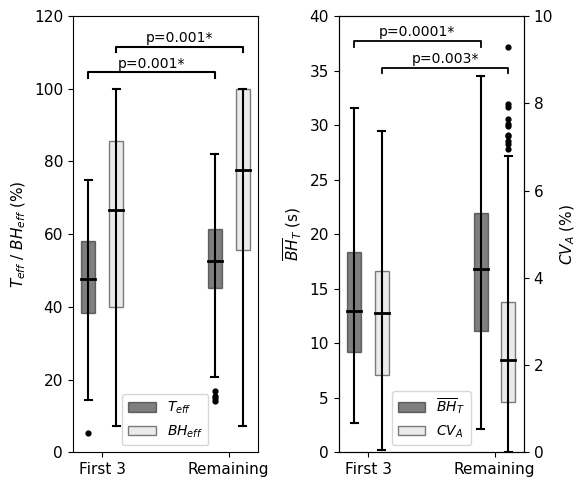

In [26]:
def plot_box_fases_TFG_final(
    input_path, output_path,

    ylim_eff=(60, 105),
    ylim_meanBH=(0.5, 3.5),
    ylim_CVamp=(1, 12),

    bracket_eff={"Initial-Final": [102, 106]},
    bracket_meanBH={"Initial-Final": 3.2},
    bracket_CVamp={"Initial-Final": 12},

    Outliers=False
):

    # ---------------------------------------------------------
    # 1. LECTURA DE DATOS
    # ---------------------------------------------------------

    fases_dir = os.path.join(output_path, "fases_TFG_final")
    os.makedirs(fases_dir, exist_ok=True)

    rows = []

    for patient in sorted(os.listdir(input_path)):
        ppath = os.path.join(input_path, patient)
        if not os.path.isdir(ppath):
            continue

        for sfolder in os.listdir(ppath):
            spath = os.path.join(ppath, sfolder)
            if not os.path.isdir(spath):
                continue

            try:
                snum = int(sfolder.split("_")[-1])
            except:
                continue

            for f in os.listdir(spath):
                if f.endswith("_results.json"):
                    with open(os.path.join(spath, f), "r") as jf:
                        content = json.load(jf)

                    s = content.get("Session", {})

                    rows.append({
                        "patient": patient,
                        "session": snum,
                        "Time_eff": s.get("Time_effectiveness", np.nan) * 100,
                        "BH_eff": s.get("BH_effectiveness", np.nan) * 100,
                        "Mean_BH": s.get("mean_BH", np.nan),
                        "CV_Amp": s.get("CV_Amp", np.nan) * 100
                    })

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ No hay datos válidos")
        return

    # ---------------------------------------------------------
    # 2. DEFINICIÓN DE FASES (5 primeras / 10 últimas)
    # ---------------------------------------------------------

    max_sessions = df.groupby("patient")["session"].max()

    def fase(row):
        if row["session"] <= 3:
            return "Initial" 
        else:
            return "Final"

    df["fase"] = df.apply(fase, axis=1)
    df = df.dropna(subset=["fase"])

    fases = ["Initial", "Final"]
    x = np.arange(2)
    width = 0.22

    # ---------------------------------------------------------
    # 3. ESTADÍSTICA BOXPLOT
    # ---------------------------------------------------------

    def compute_box(series):
        s = pd.Series(series).dropna()
        if len(s) == 0:
            return None

        q1, med, q3 = np.percentile(s, [25, 50, 75])
        iqr = q3 - q1

        lw = s[s >= q1 - 1.5 * iqr].min()
        uw = s[s <= q3 + 1.5 * iqr].max()

        out = s[(s < lw) | (s > uw)]

        return q1, med, q3, lw, uw, out

    # ---------------------------------------------------------
    # 4. FIGURA
    # ---------------------------------------------------------

    fig, axs = plt.subplots(1, 2, figsize=(6, 5))
    ax1, ax2 = axs
    ax2r = ax2.twinx()
    COLOR_BLACK = "#000000"
    COLOR_LIGHTGRAY = "#D9D9D9"


    # ================= SUBPLOT 1 =================

    metrics1 = [
        ("Time_eff", r"$T_{eff}$", COLOR_BLACK),
        ("BH_eff",   r"$BH_{eff}$", COLOR_LIGHTGRAY)
    ]


    for m, label, color in metrics1:
        offs = (metrics1.index((m, label, color)) - 0.5) * width

        for i, f in enumerate(fases):
            stats = compute_box(df[df["fase"] == f][m])
            if stats is None:
                continue

            q1, med, q3, lw, uw, out = stats

            ax1.add_patch(plt.Rectangle(
                (x[i] + offs - width/4, q1),
                width/2, q3 - q1,
                facecolor=color, edgecolor="black", alpha=0.5
            ))

            ax1.plot([x[i] + offs - width/4, x[i] + offs + width/4],
                     [med, med], color="black", lw=2)

            ax1.plot([x[i] + offs, x[i] + offs], [lw, uw], color="black")
            ax1.plot([x[i] + offs - width/8, x[i] + offs + width/8], [lw, lw], color="black")
            ax1.plot([x[i] + offs - width/8, x[i] + offs + width/8], [uw, uw], color="black")

            if Outliers and len(out) > 0:
                ax1.scatter(np.full(len(out), x[i] + offs), out, s=12, color="black")

    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(
        ["First 3", "Remaining"],
        fontsize=11
    )
    ax1.set_ylabel(r"$T_{eff}$ / $BH_{eff}$ (%)")
    ax1.set_ylim(*ylim_eff)

    ax1.legend(handles=[Patch(facecolor=c, edgecolor="black", alpha=0.5, label=l)
                        for _, l, c in metrics1], loc="lower center", fontsize=10)

    # Wilcoxon subplot 1
    for mi, (m, _, _) in enumerate(metrics1):
        w = df.pivot_table(index="patient", columns="fase", values=m).dropna()
        if len(w) >= 2:
            stat, p = wilcoxon(w["Initial"], w["Final"])
            yb = bracket_eff["Initial-Final"][mi]
            x1, x2 = x[0] + (mi-0.5)*width, x[1] + (mi-0.5)*width
            ax1.plot([x1, x1, x2, x2], [yb, yb+1.5, yb+1.5, yb], color="black")
            ax1.text(
                (x1 + x2) / 2,
                yb + 2,
                f"p={p:.3f}" + ("*" if p < 0.05 else ""),
                ha="center",
                va="bottom",
                fontsize=10
            )


    # ================= SUBPLOT 2 =================

    metrics2 = [
        ("Mean_BH", ax2,  COLOR_BLACK),
        ("CV_Amp",  ax2r, COLOR_LIGHTGRAY)
    ]

    
    for m, axis, color in metrics2:
        offs = (metrics2.index((m, axis, color)) - 0.5) * width
    
        for i, f in enumerate(fases):
            stats = compute_box(df[df["fase"] == f][m])
            if stats is None:
                continue
    
            q1, med, q3, lw, uw, out = stats
    
            axis.add_patch(plt.Rectangle(
                (x[i] + offs - width/4, q1),
                width/2, q3 - q1,
                facecolor=color,
                edgecolor="black",
                alpha=0.5
            ))
    
            axis.plot(
                [x[i] + offs - width/4, x[i] + offs + width/4],
                [med, med],
                color="black", lw=2
            )
    
            axis.plot([x[i] + offs, x[i] + offs], [lw, uw], color="black")
            axis.plot([x[i] + offs - width/8, x[i] + offs + width/8], [lw, lw], color="black")
            axis.plot([x[i] + offs - width/8, x[i] + offs + width/8], [uw, uw], color="black")
    
            if Outliers and len(out) > 0:
                axis.scatter(np.full(len(out), x[i] + offs), out, s=12, color="black")
    
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(
        ["First 3", "Remaining"],
        fontsize=11
    )

    ax2.set_ylabel(r"$\overline{BH}_T$ (s)")
    ax2r.set_ylabel(r"$CV_A$ (%)")
    
    ax2.set_ylim(*ylim_meanBH)
    ax2r.set_ylim(*ylim_CVamp)
    
    ax2.legend(handles=[
        Patch(facecolor=COLOR_BLACK, edgecolor="black", alpha=0.5, label=r"$\overline{BH}_T$"),
        Patch(facecolor=COLOR_LIGHTGRAY, edgecolor="black", alpha=0.5, label=r"$CV_A$")
    ], loc="lower center",fontsize=10)
    
    
    # -------- Wilcoxon + brackets (idéntico a subplot 1) --------
        
        # --- Mean BH ---
    df_w = df.pivot_table(index="patient", columns="fase", values="Mean_BH").dropna()
    if df_w.shape[0] >= 2:
        stat, p = wilcoxon(df_w["Initial"], df_w["Final"])
        ptxt = f"p={p:.4f}" + ("*" if p < 0.05 else "")
    
        yb = bracket_meanBH["Initial-Final"]
        x1 = x[0] - width/2
        x2 = x[1] - width/2
    
        ax2.plot([x1, x1, x2, x2],
                      [yb, yb+0.5, yb+0.5, yb],
                      color="black", lw=1.3)
        ax2.text((x1 + x2)/2, yb + 0.7, ptxt,
                      ha="center", va="bottom", fontsize=10)
    
    
    # --- CV Amp ---
    df_w2 = df.pivot_table(index="patient", columns="fase", values="CV_Amp").dropna()
    if df_w2.shape[0] >= 2:
        stat, p = wilcoxon(df_w2["Initial"], df_w2["Final"])
        ptxt = f"p={p:.3f}" + ("*" if p < 0.05 else "")
    
        yb2 = bracket_CVamp["Initial-Final"]
        x1 = x[0] + width/2
        x2 = x[1] + width/2
    
        ax2r.plot([x1, x1, x2, x2],
                       [yb2, yb2+0.1, yb2+0.1, yb2],
                       color="black", lw=1.3)
        ax2r.text((x1 + x2)/2, yb2 + 0.15, ptxt,
                       ha="center", va="bottom", fontsize=10)
    
    plt.tight_layout()
    save = os.path.join(fases_dir, "Fases_boxplot_TFG_final_15fxOnly.png")
    plt.savefig(save, dpi=750)
    print(f"✅ Gráfico guardado en: {save}")

    
input1 = r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes"
input2 = r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Plots"

plot_box_fases_TFG_final(
    input1,
    input2,

    ylim_eff=(0, 120),
    ylim_meanBH=(0, 40),
    ylim_CVamp=(0, 10),

    bracket_eff={"Initial-Final": [103, 110]},
    bracket_meanBH={"Initial-Final": 37.2},
    bracket_CVamp={"Initial-Final": 8.7},

    Outliers=True   # ← pon True si quieres verlos
)
    


---

## 🧩 `Quantitative_evo_3fx`

### Objetivo  
Esta función estudia los **efectos de aprendizaje temprano** en la ejecución de la técnica DIBH comparando las tres primeras fracciones de tratamiento con el resto del curso terapéutico. El análisis tiene como finalidad determinar si se producen mejoras significativas en las primeras sesiones, lo que podría justificar la implementación de protocolos de entrenamiento previos al inicio de la radioterapia.


### Estructura de los datos de entrada  
La estructura de directorios requerida es idéntica a la utilizada en `Quantitative_evolution`:

basepath/

    └── paciente_i/
    
        └── sesion_j/
        
            └── patientID_session_results.json
            

La función es robusta frente a esquemas de fraccionamiento distintos, incluyendo pacientes tratados con 5 o 15 fracciones.


### Parámetros analizados  
Para mantener la coherencia metodológica, se analizan los mismos parámetros cuantitativos:

- **Time_effectiveness** [%]  
- **BH_effectiveness** [%]  
- **CV_Amp** [%]  
- **mean_BH** [s]


### Definición de fases  
Para cada paciente, las sesiones se subdividen en:

- **Fase Temprana**: sesiones 1–3  
- **Fase Tardía**: sesiones 4–N  

donde *N* corresponde al número total de fracciones disponibles (por ejemplo, 5 o 15).  
Los pacientes con menos de cuatro sesiones no se incluyen en esta comparación.


### Metodología  
Para cada paciente y cada parámetro:

1. Se calculan valores medios independientes para la fase Temprana y la fase Tardía.
2. La mejora en el desempeño se define como:
\[
\text{Mejora} = \text{Media Temprana} - \text{Media Tardía}
\]

A nivel poblacional:

- Se calcula la **mediana** y el **IQR** de cada parámetro en las fases Temprana y Tardía.
- Se calcula la **mediana de la mejora** y su correspondiente **IQR** entre ambas fases.


### Salida  
La función imprime, para cada parámetro:

- Mediana ± IQR en la fase Temprana.
- Mediana ± IQR en la fase Tardía.
- Mediana ± IQR de la mejora Temprana vs. Tardía.

No se devuelve ningún valor, manteniendo un enfoque descriptivo y exploratorio coherente con el resto del análisis.

In [29]:
def Quantitative_evo_3fx(basepath):
    parameters = {
        "Time_effectiveness": 100.0,
        "BH_effectiveness": 100.0,
        "CV_Amp": 100.0,
        "mean_BH": 1.0
    }

    patient_phase_means = defaultdict(dict)

    # -----------------------------
    # 1. Data extraction
    # -----------------------------
    for patient in sorted(os.listdir(basepath)):
        patient_path = os.path.join(basepath, patient)
        if not os.path.isdir(patient_path):
            continue

        session_values = defaultdict(dict)

        for session in os.listdir(patient_path):
            session_path = os.path.join(patient_path, session)
            if not os.path.isdir(session_path):
                continue

            json_files = [
                f for f in os.listdir(session_path)
                if f.endswith("_results.json")
            ]
            if not json_files:
                continue

            try:
                with open(os.path.join(session_path, json_files[0]), "r") as f:
                    data = json.load(f)

                session_number = int(session.split("_")[-1])
                session_data = data["Session"]

                for param, scale in parameters.items():
                    if param in session_data:
                        session_values[session_number][param] = (
                            session_data[param] * scale
                        )
            except Exception:
                continue

        if len(session_values) < 4:
            continue  # Need at least 3 vs rest

        early_sessions = [s for s in session_values if s <= 3]
        late_sessions = [s for s in session_values if s > 3]

        for param in parameters.keys():
            early_vals = [
                session_values[s][param]
                for s in early_sessions
                if param in session_values[s]
            ]
            late_vals = [
                session_values[s][param]
                for s in late_sessions
                if param in session_values[s]
            ]

            if early_vals and late_vals:
                patient_phase_means[patient][param] = {
                    "Early": np.mean(early_vals),
                    "Late": np.mean(late_vals)
                }

    # -----------------------------
    # 2. Collect distributions
    # -----------------------------
    phase_distributions = defaultdict(lambda: defaultdict(list))
    improvements = defaultdict(list)

    for patient, params in patient_phase_means.items():
        for param, values in params.items():
            early = values["Early"]
            late = values["Late"]

            phase_distributions[param]["Early"].append(early)
            phase_distributions[param]["Late"].append(late)

            improvements[param].append(late - early)

    # -----------------------------
    # 3. Print results
    # -----------------------------
    print("\n===== Quantitative Evolution: First 3 Fractions vs Remainder =====\n")

    for param in parameters.keys():
        print(f"\nParameter: {param}")

        # Phase statistics
        for phase in ["Early", "Late"]:
            values = phase_distributions[param][phase]
            if values:
                med = np.median(values)
                q1 = np.percentile(values, 25)
                q3 = np.percentile(values, 75)
                print(
                    f"  {phase} phase: Median = {med:.2f} "
                    f"(IQR: [{q1:.2f}, {q3:.2f}])"
                )
            else:
                print(f"  {phase} phase: Median = NaN (IQR: [NaN, NaN])")

        # Improvement statistics
        values = improvements[param]
        if values:
            med = np.median(values)
            q1 = np.percentile(values, 25)
            q3 = np.percentile(values, 75)
            print(
                f"  Median improvement Early vs Late: "
                f"{med:.2f} (IQR: [{q1:.2f}, {q3:.2f}])"
            )
        else:
            print(
                f"  Median improvement Early vs Late: "
                f"NaN (IQR: [NaN, NaN])"
            )


basepath=r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes"
Quantitative_evo_3fx(basepath)


===== Quantitative Evolution: First 3 Fractions vs Remainder =====


Parameter: Time_effectiveness
  Early phase: Median = 48.37 (IQR: [40.94, 55.37])
  Late phase: Median = 51.75 (IQR: [48.40, 56.39])
  Median improvement Early vs Late: 3.37 (IQR: [-1.10, 9.05])

Parameter: BH_effectiveness
  Early phase: Median = 63.61 (IQR: [49.13, 79.07])
  Late phase: Median = 76.94 (IQR: [57.30, 86.22])
  Median improvement Early vs Late: 8.11 (IQR: [-2.36, 18.58])

Parameter: CV_Amp
  Early phase: Median = 3.09 (IQR: [2.29, 3.75])
  Late phase: Median = 2.23 (IQR: [1.72, 3.46])
  Median improvement Early vs Late: -0.40 (IQR: [-1.40, 0.25])

Parameter: mean_BH
  Early phase: Median = 13.04 (IQR: [9.89, 17.57])
  Late phase: Median = 15.59 (IQR: [12.44, 20.82])
  Median improvement Early vs Late: 2.38 (IQR: [0.22, 4.53])


---
### Función `plot_fases_TFG_final`

La función `plot_fases_TFG_final` tiene como objetivo analizar la evolución de diferentes parámetros respiratorios a lo largo del tratamiento DIBH dividiendo las sesiones en tres fases temporales consecutivas de igual tamaño: *Initial*, *Middle* y *Final*, correspondientes a bloques de cinco sesiones cada uno. Este enfoque permite estudiar tendencias progresivas en el control respiratorio del paciente a medida que avanza el tratamiento.

En primer lugar, la función recorre la estructura de directorios de los pacientes y lee los archivos de resultados de cada sesión en formato `.json`. A partir de estos archivos se extraen las métricas de interés: $T_{eff}$, $BH_{eff}$, $\overline{BH}_T$ y $CV_A$, que se almacenan conjuntamente en un `DataFrame` para su posterior procesamiento.

Cada sesión se asigna a una de las tres fases temporales en función de su índice de sesión, permitiendo agrupar de forma homogénea tratamientos tanto de 15 fracciones como de 5 fracciones. Esta estrategia garantiza que el análisis sea consistente entre pacientes con distintos esquemas de tratamiento.

La visualización se realiza mediante boxplots clásicos construidos manualmente, utilizando el mismo criterio estadístico que en el resto del trabajo (mediana, rango intercuartílico y *whiskers* definidos por 1.5·IQR). Los boxplots se representan con colores negro y gris claro, manteniendo coherencia visual con las demás figuras del TFG y facilitando la comparación entre parámetros.

La figura se organiza en dos subgráficos. El primero muestra la evolución de la efectividad temporal y del *breath-hold* ($T_{eff}$ y $BH_{eff}$) a lo largo de las tres fases. El segundo subgráfico representa la evolución del valor medio del *breath-hold* y de la variabilidad de la amplitud respiratoria ($\overline{BH}_T$ y $CV_A$), utilizando un eje secundario para acomodar las diferentes escalas.

Para cuantificar la significancia estadística de los cambios observados entre fases consecutivas y no consecutivas, se aplica el test de Wilcoxon para muestras emparejadas en todas las comparaciones relevantes (*Initial–Middle*, *Middle–Final* e *Initial–Final*). Los valores *p* se indican directamente sobre la figura mediante anotaciones y corchetes, permitiendo una interpretación inmediata de los resultados.

La función finaliza guardando la figura generada con alta resolución en el directorio de salida especificado, de forma que pueda ser utilizada directamente en la memoria del TFG o en presentaciones asociadas al trabajo.


C:\Users\Mario\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Mario\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


✅ Gráfico guardado en: C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Plots\fases_TFG_final\Fases_TFG_final.png


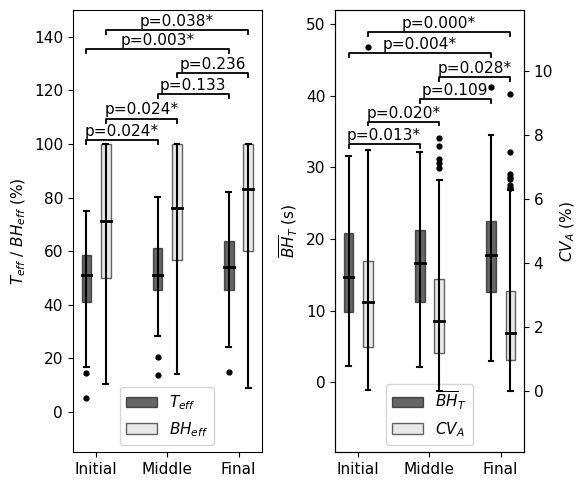

In [6]:
def plot_fases_TFG_final(
    input_path,
    output_path,

    ylim_eff=(60, 105),
    ylim_meanBH=(0.5, 3.5),
    ylim_CVamp=(1, 12),

    bracket_eff={
        "Initial-Middle": [90, 94],
        "Middle-Final":   [96, 100],
        "Initial-Final":  [102, 106]
    },
    bracket_meanBH={
        "Initial-Middle": 2.8,
        "Middle-Final":   3.0,
        "Initial-Final":  3.2
    },
    bracket_CVamp={
        "Initial-Middle": 11,
        "Middle-Final":   11.5,
        "Initial-Final":  12
    }
):

    # ---------------------------------------------------------
    # FUENTE GLOBAL
    # ---------------------------------------------------------
    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11
    })

    # ---------------------------------------------------------
    # 1. LECTURA DE DATOS
    # ---------------------------------------------------------
    fases_dir = os.path.join(output_path, "fases_TFG_final")
    os.makedirs(fases_dir, exist_ok=True)

    rows = []

    for patient in sorted(os.listdir(input_path)):
        ppath = os.path.join(input_path, patient)
        if not os.path.isdir(ppath):
            continue

        for sfolder in sorted(os.listdir(ppath)):
            spath = os.path.join(ppath, sfolder)
            if not os.path.isdir(spath):
                continue

            try:
                snum = int(sfolder.split("_")[-1])
            except:
                continue

            for f in os.listdir(spath):
                if f.endswith("_results.json"):
                    with open(os.path.join(spath, f), "r") as jf:
                        content = json.load(jf)

                    s = content.get("Session", {})

                    rows.append({
                        "patient": patient,
                        "session": snum,
                        "Time_eff": s.get("Time_effectiveness", np.nan) * 100,
                        "BH_eff": s.get("BH_effectiveness", np.nan) * 100,
                        "Mean_BH": s.get("mean_BH", np.nan),
                        "CV_Amp": s.get("CV_Amp", np.nan) * 100
                    })

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ No hay datos válidos")
        return

    # ---------------------------------------------------------
    # 2. FASES (5–5–5)
    # ---------------------------------------------------------
    def fase(s):
        if s <= 5:
            return "Initial"
        elif s <= 10:
            return "Middle"
        return "Final"

    df["fase"] = df["session"].apply(fase)

    fases = ["Initial", "Middle", "Final"]
    x = np.arange(3) * 1.1   # menos espacio entre fases
    width = 0.3# boxes más anchos


    # ---------------------------------------------------------
    # 3. BOXPLOT CLÁSICO
    # ---------------------------------------------------------
    def compute_box(series):
        s = pd.Series(series).dropna()
        if len(s) == 0:
            return None

        q1, med, q3 = np.percentile(s, [25, 50, 75])
        iqr = q3 - q1

        lw = s[s >= q1 - 1.5 * iqr].min()
        uw = s[s <= q3 + 1.5 * iqr].max()

        out = s[(s < lw) | (s > uw)]

        return q1, med, q3, lw, uw, out

    COLOR_BLACK = "#000000"
    COLOR_LIGHTGRAY = "#D9D9D9"

    # ---------------------------------------------------------
    # 4. FIGURA
    # ---------------------------------------------------------
    fig, axs = plt.subplots(1, 2, figsize=(6, 5))
    ax1, ax2 = axs
    ax2r = ax2.twinx()

    # ================= SUBPLOT 1 =================
    metrics1 = [
        ("Time_eff", r"$T_{eff}$", COLOR_BLACK),
        ("BH_eff",   r"$BH_{eff}$", COLOR_LIGHTGRAY)
    ]

    for m, label, color in metrics1:
        offs = (metrics1.index((m, label, color)) - 0.5) * width

        for i, f in enumerate(fases):
            stats = compute_box(df[df["fase"] == f][m])
            if stats is None:
                continue

            q1, med, q3, lw, uw, out = stats

            ax1.add_patch(plt.Rectangle(
                (x[i] + offs - width/4, q1),
                width/2, q3 - q1,
                facecolor=color, edgecolor="black", alpha=0.6
            ))

            ax1.plot([x[i] + offs - width/4, x[i] + offs + width/4],
                     [med, med], color="black", lw=2)

            ax1.plot([x[i] + offs, x[i] + offs], [lw, uw], color="black")
            ax1.plot([x[i] + offs - width/8, x[i] + offs + width/8], [lw, lw], color="black")
            ax1.plot([x[i] + offs - width/8, x[i] + offs + width/8], [uw, uw], color="black")
            ax1.scatter(
                np.full(len(out), x[i] + offs),
                out,
                color="black",
                s=12,
                zorder=3
            )

    ax1.set_xticks(x)
    ax1.set_xticklabels(fases)
    ax1.set_ylabel(r"$T_{eff}$ / $BH_{eff}$ (%)", fontsize=11)
    ax1.set_ylim(*ylim_eff)
    ax1.tick_params(labelsize=11)

    ax1.legend(handles=[
        Patch(facecolor=COLOR_BLACK, edgecolor="black", alpha=0.6, label=r"$T_{eff}$"),
        Patch(facecolor=COLOR_LIGHTGRAY, edgecolor="black", alpha=0.6, label=r"$BH_{eff}$")
    ], loc="lower center", fontsize=11)

    # -------- Wilcoxon SUBPLOT 1 --------
    comps = [("Initial", "Middle"), ("Middle", "Final"), ("Initial", "Final")]
    comp_names = ["Initial-Middle", "Middle-Final", "Initial-Final"]

    for ci, (fa, fb) in enumerate(comps):
        for mi, (m, _, _) in enumerate(metrics1):
            df_w = df.pivot_table(index="patient", columns="fase", values=m).dropna()
            if df_w.shape[0] < 2:
                continue

            _, p = wilcoxon(df_w[fa], df_w[fb])
            ptxt = f"p={p:.3f}" + ("*" if p < 0.05 else "")

            yb = bracket_eff[comp_names[ci]][mi]
            x1 = x[fases.index(fa)] + (mi - 0.5) * width
            x2 = x[fases.index(fb)] + (mi - 0.5) * width

            ax1.plot([x1, x1, x2, x2],
                     [yb, yb + 1.5, yb + 1.5, yb],
                     color="black", lw=1.3)

            ax1.text((x1 + x2) / 2, yb + 2, ptxt,
                     ha="center", va="bottom", fontsize=11)

    # ================= SUBPLOT 2 =================
    metrics2 = [
        ("Mean_BH", ax2, COLOR_BLACK, ""),
        ("CV_Amp",  ax2r, COLOR_LIGHTGRAY, "")
    ]

    for m, axis, color, hatch in metrics2:
        offs = (metrics2.index((m, axis, color, hatch)) - 0.5) * width

        for i, f in enumerate(fases):
            stats = compute_box(df[df["fase"] == f][m])
            if stats is None:
                continue

            q1, med, q3, lw, uw, out = stats

            axis.add_patch(plt.Rectangle(
                (x[i] + offs - width/4, q1),
                width/2, q3 - q1,
                facecolor=color, edgecolor="black",
                hatch=hatch, alpha=0.6
            ))

            axis.plot([x[i] + offs - width/4, x[i] + offs + width/4],
                      [med, med], color="black", lw=2)

            axis.plot([x[i] + offs, x[i] + offs], [lw, uw], color="black")
            axis.plot([x[i] + offs - width/8, x[i] + offs + width/8], [lw, lw], color="black")
            axis.plot([x[i] + offs - width/8, x[i] + offs + width/8], [uw, uw], color="black")
            axis.scatter(
                np.full(len(out), x[i] + offs),
                out,
                color="black",
                s=12,
                zorder=3
            )

    ax2.set_xticks(x)
    ax2.set_xticklabels(fases)
    ax2.set_ylabel(r"$\overline{BH}_T$ (s)", fontsize=11)
    ax2r.set_ylabel(r"$CV_A$ (%)", fontsize=11)

    ax2.set_ylim(*ylim_meanBH)
    ax2r.set_ylim(*ylim_CVamp)

    ax2.tick_params(labelsize=11)
    ax2r.tick_params(labelsize=11)

    ax2.legend(handles=[
        Patch(facecolor=COLOR_BLACK, edgecolor="black", alpha=0.6, label=r"$\overline{BH}_T$"),
        Patch(facecolor=COLOR_LIGHTGRAY, edgecolor="black", alpha=0.6, label=r"$CV_A$")
    ], loc="lower center", fontsize=11)
    
    # -------- Wilcoxon SUBPLOT 2 (Mean BH y CV Amp) --------

    comps = [("Initial", "Middle"), ("Middle", "Final"), ("Initial", "Final")]
    comp_names = ["Initial-Middle", "Middle-Final", "Initial-Final"]
    
    for ci, (fa, fb) in enumerate(comps):
    
        # --- Mean BH (eje izquierdo) ---
        df_w = df.pivot_table(
            index="patient",
            columns="fase",
            values="Mean_BH"
        ).dropna()
    
        if df_w.shape[0] >= 2:
            _, p = wilcoxon(df_w[fa], df_w[fb])
            ptxt = f"p={p:.3f}" + ("*" if p < 0.05 else "")
    
            yb = bracket_meanBH[comp_names[ci]]
            x1 = x[fases.index(fa)] - width / 2
            x2 = x[fases.index(fb)] - width / 2
    
            ax2.plot(
                [x1, x1, x2, x2],
                [yb, yb + 0.5, yb + 0.5, yb],
                color="black", lw=1.3
            )
    
            ax2.text(
                (x1 + x2) / 2,
                yb + 0.7,
                ptxt,
                ha="center",
                va="bottom",
                fontsize=11
            )
    
        # --- CV Amp (eje derecho) ---
        df_w2 = df.pivot_table(
            index="patient",
            columns="fase",
            values="CV_Amp"
        ).dropna()
    
        if df_w2.shape[0] >= 2:
            _, p = wilcoxon(df_w2[fa], df_w2[fb])
            ptxt = f"p={p:.3f}" + ("*" if p < 0.05 else "")
    
            yb2 = bracket_CVamp[comp_names[ci]]
            x1 = x[fases.index(fa)] + width / 2
            x2 = x[fases.index(fb)] + width / 2
    
            ax2r.plot(
                [x1, x1, x2, x2],
                [yb2, yb2 + 0.1, yb2 + 0.1, yb2],
                color="black", lw=1.3
            )
    
            ax2r.text(
                (x1 + x2) / 2,
                yb2 + 0.15,
                ptxt,
                ha="center",
                va="bottom",
                fontsize=11
            )
    
    plt.tight_layout()
    save = os.path.join(fases_dir, "Fases_TFG_final.png")
    plt.savefig(save, dpi=700)
    print(f"✅ Gráfico guardado en: {save}")


input1 = r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes 15fx"
input2 = r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Plots"
plot_fases_TFG_final(
    input1,
    input2,

    ylim_eff=(-15, 150),
    ylim_meanBH=(-9.8, 52),
    ylim_CVamp=(-1.9, 11.9),

    bracket_eff={
        "Initial-Middle": [100, 108],
        "Middle-Final":   [117, 125],
        "Initial-Final":  [134, 141]
    },
    bracket_meanBH={
        "Initial-Middle": 32.75,
        "Middle-Final":   39,
        "Initial-Final":  45.5
    },
    bracket_CVamp={
        "Initial-Middle": 8.3,
        "Middle-Final":   9.7,
        "Initial-Final":  11.1
    }
)


---
## 🧩 `Quantitative_evolution`

### Objetivo  
Esta función realiza un análisis longitudinal cuantitativo de métricas de rendimiento respiratorio durante tratamientos con DIBH, subdividiendo el curso del tratamiento en tres fases clínicamente relevantes: **Inicial**, **Intermedia** y **Final**. El objetivo es evaluar si el desempeño de los pacientes mejora progresivamente a lo largo del tratamiento en ausencia de cualquier tipo de entrenamiento estructurado, seguimiento específico o intervención adicional por parte del personal sanitario.


### Estructura de los datos de entrada  
La función espera una estructura de directorios organizada de la siguiente forma:

basepath/

 └── patient_i/
 
     └── session_j/
     
         └── patientID_session_results.json
         
         

Cada archivo JSON debe contener un campo `Session` con los parámetros cuantitativos extraídos a nivel de sesión a partir del análisis de las trazas respiratorias.


### Parámetros analizados  
Se consideran los siguientes parámetros a nivel de sesión:

- **Time_effectiveness** [%]  
- **BH_effectiveness** [%]  
- **CV_Amp** [%]  
- **mean_BH** [s]

Los parámetros expresados como fracción se escalan internamente por un factor 100 para facilitar su interpretación en porcentaje.


### Definición de fases  
Para cada paciente, las sesiones de tratamiento se agrupan en tres fases:

- **Fase Inicial**: sesiones 1–5  
- **Fase Intermedia**: sesiones 6–10  
- **Fase Final**: sesiones 11–15  

Esta subdivisión permite capturar fenómenos de adaptación temprana, estabilización intermedia y comportamiento tardío durante el tratamiento.


### Metodología  
Para cada paciente y cada parámetro:

1. Los valores a nivel de sesión se promedian dentro de cada fase, obteniendo **valores medios por paciente y fase**.
2. Las mejoras entre fases se calculan mediante diferencias simples:
   - Inicial − Intermedia  
   - Intermedia − Final  
   - Inicial − Final  

A nivel poblacional:

- Se calcula la **mediana** y el **rango intercuartílico (IQR)** de cada parámetro para las fases Inicial, Intermedia y Final.
- Se calcula la **mediana de la mejora** y su correspondiente **IQR** para cada comparación entre fases.


### Salida  
La función no devuelve ningún objeto.  
Todos los resultados se presentan mediante instrucciones `print`, incluyendo:

- Mediana ± IQR de cada parámetro en cada fase.
- Mediana ± IQR de las mejoras entre fases.

Este formato está pensado para facilitar la interpretación directa de los resultados y su uso posterior en análisis no paramétricos y visualizaciones (por ejemplo, boxplots).


In [27]:
def Quantitative_evolution(basepath):
    parameters = {
        "Time_effectiveness": 100.0,
        "BH_effectiveness": 100.0,
        "CV_Amp": 100.0,
        "mean_BH": 1.0
    }

    phase_definition = {
        "Initial": range(1, 6),
        "Middle": range(6, 11),
        "Final": range(11, 16)
    }

    patient_phase_means = defaultdict(lambda: defaultdict(dict))

    # -----------------------------
    # 1. Data extraction
    # -----------------------------
    for patient in sorted(os.listdir(basepath)):
        patient_path = os.path.join(basepath, patient)
        if not os.path.isdir(patient_path):
            continue

        session_values = {}

        for session in os.listdir(patient_path):
            session_path = os.path.join(patient_path, session)
            if not os.path.isdir(session_path):
                continue

            json_files = [
                f for f in os.listdir(session_path)
                if f.endswith("_results.json")
            ]
            if not json_files:
                continue

            try:
                with open(os.path.join(session_path, json_files[0]), "r") as f:
                    data = json.load(f)

                session_number = int(session.split("_")[-1])
                session_data = data["Session"]

                for param, scale in parameters.items():
                    if param in session_data:
                        session_values[(param, session_number)] = (
                            session_data[param] * scale
                        )
            except Exception:
                continue

        for param in parameters.keys():
            for phase, sessions in phase_definition.items():
                values = [
                    session_values[(param, s)]
                    for s in sessions
                    if (param, s) in session_values
                ]
                patient_phase_means[patient][phase][param] = (
                    np.mean(values) if values else np.nan
                )

    # -----------------------------
    # 2. Collect phase distributions
    # -----------------------------
    phase_distributions = defaultdict(lambda: defaultdict(list))
    improvements = defaultdict(lambda: defaultdict(list))

    for patient, phases in patient_phase_means.items():
        for param in parameters.keys():
            ini = phases["Initial"][param]
            mid = phases["Middle"][param]
            fin = phases["Final"][param]

            if not np.isnan(ini):
                phase_distributions[param]["Initial"].append(ini)
            if not np.isnan(mid):
                phase_distributions[param]["Middle"].append(mid)
            if not np.isnan(fin):
                phase_distributions[param]["Final"].append(fin)

            if not np.isnan(ini) and not np.isnan(mid):
                improvements[param]["Initial-Middle"].append(mid - ini)
            if not np.isnan(mid) and not np.isnan(fin):
                improvements[param]["Middle-Final"].append(fin - mid)
            if not np.isnan(ini) and not np.isnan(fin):
                improvements[param]["Initial-Final"].append(fin - ini)

    # -----------------------------
    # 3. Print results
    # -----------------------------
    print("\n===== Quantitative Evolution Analysis =====\n")

    for param in parameters.keys():
        print(f"\nParameter: {param}")

        # Phase statistics
        for phase in ["Initial", "Middle", "Final"]:
            values = phase_distributions[param][phase]
            if values:
                med = np.median(values)
                q1 = np.percentile(values, 25)
                q3 = np.percentile(values, 75)
                print(
                    f"  {phase} phase: Median = {med:.2f} "
                    f"(IQR: [{q1:.2f}, {q3:.2f}])"
                )
            else:
                print(f"  {phase} phase: Median = NaN (IQR: [NaN, NaN])")

        # Improvement statistics
        for comp in ["Initial-Middle", "Middle-Final", "Initial-Final"]:
            values = improvements[param][comp]
            if values:
                med = np.median(values)
                q1 = np.percentile(values, 25)
                q3 = np.percentile(values, 75)
                print(
                    f"  Median improvement {comp}: "
                    f"{med:.2f} (IQR: [{q1:.2f}, {q3:.2f}])"
                )
            else:
                print(
                    f"  Median improvement {comp}: "
                    f"NaN (IQR: [NaN, NaN])"
                )

            
basepath=r"C:\Users\Mario\Desktop\Fisica\TFG Clinic\TFG\DIBH\PARA EL TFG\Pacientes 15fx"
Quantitative_evolution(basepath)


===== Quantitative Evolution Analysis =====


Parameter: Time_effectiveness
  Initial phase: Median = 51.75 (IQR: [43.27, 54.77])
  Middle phase: Median = 51.63 (IQR: [46.58, 57.32])
  Final phase: Median = 53.81 (IQR: [47.81, 59.62])
  Median improvement Initial-Middle: 2.56 (IQR: [-1.92, 6.81])
  Median improvement Middle-Final: 2.30 (IQR: [-3.01, 5.97])
  Median improvement Initial-Final: 5.16 (IQR: [-3.11, 11.96])

Parameter: BH_effectiveness
  Initial phase: Median = 71.93 (IQR: [55.72, 83.66])
  Middle phase: Median = 77.07 (IQR: [61.31, 87.57])
  Final phase: Median = 79.62 (IQR: [62.47, 91.16])
  Median improvement Initial-Middle: 4.81 (IQR: [-2.00, 15.09])
  Median improvement Middle-Final: 3.87 (IQR: [-6.01, 10.45])
  Median improvement Initial-Final: 6.34 (IQR: [-7.21, 25.43])

Parameter: CV_Amp
  Initial phase: Median = 2.87 (IQR: [2.10, 3.57])
  Middle phase: Median = 2.54 (IQR: [1.58, 3.40])
  Final phase: Median = 2.03 (IQR: [1.52, 3.14])
  Median improvement Initial-Mi